# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.637590,True,6.520693
1,0.801579,True,5.108779
2,0.881458,True,6.467110
3,1.027056,True,7.864867
4,-0.413940,True,4.238949
...,...,...,...
995,-2.033826,False,-4.672260
996,0.365811,True,6.945674
997,0.578434,True,6.579019
998,-0.980167,True,2.991995


<AxesSubplot:xlabel='v0'>

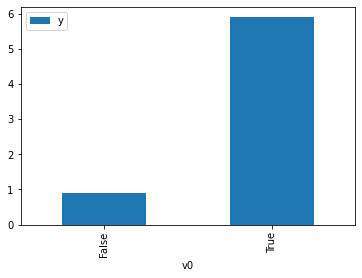

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

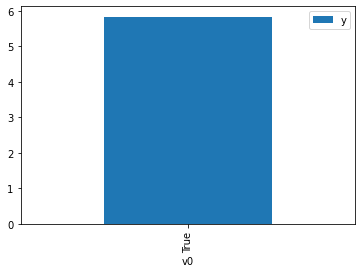

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.579442,False,4.658501,0.030291,33.012818
1,0.554920,False,1.477736,0.221619,4.512239
2,-0.064982,False,-0.911863,0.520206,1.922316
3,-0.040639,False,0.488671,0.507089,1.972039
4,1.433814,False,3.050066,0.041012,24.383177
...,...,...,...,...,...
995,-0.497993,False,-0.110081,0.733971,1.362451
996,0.870370,False,-0.180057,0.126014,7.935650
997,1.822110,False,6.324910,0.018171,55.031483
998,0.300758,False,0.346585,0.330035,3.029985


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.204140,True,2.215767,0.073236,13.654566
1,0.280433,True,5.303875,0.660201,1.514690
2,0.343850,True,4.687326,0.690184,1.448890
3,0.266575,True,5.723177,0.653463,1.530308
4,1.365876,True,7.593208,0.952821,1.049515
...,...,...,...,...,...
995,2.759252,True,10.195722,0.997554,1.002452
996,0.467647,True,4.917021,0.744218,1.343692
997,0.650123,True,5.974208,0.811778,1.231864
998,1.297095,True,7.577031,0.945685,1.057434


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          1.662e+04
Date:                Tue, 16 Aug 2022   Prob (F-statistic):                        0.00
Time:                        15:09:18   Log-Likelihood:                         -1400.3
No. Observations:                1000   AIC:                                      2805.
Df Residuals:                     998   BIC:                                      2814.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.1617      0.038     56.876      0.000       2.087       2.236
x2             4.9499      0.051     97.982      0.000       4.851       5.049
==============================================================================
Omnibus:                        4.500   Durbin-Watson:                   2.095
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.572
Skew:                           0.161   Prob(JB):                        0.102
Kurtosis:                       2.921   Cond. No.                         2.25
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""